### Predict Sahel Rainfall with CICMoD dataset

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) data set (https://github.com/MarcoLandtHayen/climate_index_collection) to predict Sahel Precipitation anomalies ("Sahel rainfall").

This work is inspired by [Badr et al., 2014](https://doi.org/10.1175/JAMC-D-13-0181.1): They tried to predict summertime (July–September) Sahel rainfall anomalies using indices of springtime (April–June) sea-surface temperature (SST) and sea air temperature (SAT) anomalies. Principal component analysis was used to remove multicollinearity between predictor variables.

To follow this approach, we use **April to June mean index values as predictors** to predict **July to September seasonal sum of Sahel precipitation anomaly index**. We omit applying principal component analysis. And, opposed to [Badr et al., 2014](https://doi.org/10.1175/JAMC-D-13-0181.1), we include sea-surface salinity (SSS) anomalies as additional input feature.

**Outline in this experiment:**
- Start with **linear regression** as benchmark.
- Try **multilayer perceptron (MLP) model** in a single-run experiment.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy as sp

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import (
    SGD,
    Adam,
)
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from cicmod_application.preprocessing import split_sequence

from numpy.testing import assert_allclose, assert_almost_equal

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load data

Load collection of climate indices directly from GitHub release.

In [2]:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2022.12.15.1/climate_indices.csv"
)
climind = pd.read_csv(data_url)

# Set index: Month BEFORE year, since we want to group by month and get seasonal mean / sum for each year.
climind = climind.set_index(["model","month","year","index"]).unstack(level=-1)["value"]
climind

index                  AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
model month year                                                               
CESM  1     1    -0.045584  0.878723  1.793537  2.277095  1.539571  1.494980   
            2     0.065762 -0.369939 -0.411301 -0.604617 -0.543775 -0.472225   
            3     0.093188 -0.273633  0.175905  0.360535  0.817109  0.625345   
            4     0.100560  1.645187  2.363455  2.109603  1.037441 -1.710669   
            5     0.006717 -0.298098 -1.259673 -1.511350 -1.404290 -1.297533   
...                    ...       ...       ...       ...       ...       ...   
FOCI  12    996  -0.045785 -0.226950 -0.837139 -1.329104 -1.767935 -2.489885   
            997  -0.140739  0.336926  0.372891  0.363424  0.289976 -2.476904   
            998  -0.031140 -0.168636  0.051378  0.228499  0.604563 -0.320422   
            999   0.049995  0.103462  0.036816 -0.182372 -0.070128  0.353078   
            1000 -0.006059  0.284155  0.622142  1.097104  1.292274 -0.762554   

index               NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA  \
model month year                                            ...             
CESM  1     1     1.571751 -0.624027  0.354552   -0.000226  ...  0.377755   
            2    -0.918063 -0.426188  1.186967   -0.002682  ...  0.006887   
            3    -0.391640 -1.888244  0.922896    0.009889  ... -0.138440   
            4    -2.133493  0.272794  1.263296    0.000170  ... -0.563790   
            5    -3.603766  0.062115  0.092897    0.005747  ...  0.187125   
...                    ...       ...       ...         ...  ...       ...   
FOCI  12    996  -3.539256  0.067635  0.916682   -0.004333  ...  0.738453   
            997  -3.147132 -0.041524  0.700469   -0.006278  ...  0.020022   
            998  -0.936924  1.923619  0.455950   -0.003692  ...  0.373719   
            999   0.325810  0.536015 -0.957125    0.002825  ... -0.243904   
            1000 -0.685174  0.324010 -0.595900    0.072165  ... -0.616161   

index               SSS_NA    SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED  \
model month year                                                               
CESM  1     1     0.361125 -0.650658  0.001022  0.483008  0.070793  0.032231   
            2    -0.168227  0.060719 -0.216479 -0.462306  0.053236  0.071033   
            3    -0.175914 -0.342111 -0.563534 -0.098334  0.124467  0.105941   
            4    -0.535536  0.197418 -0.339864  0.492548  0.269565 -0.064848   
            5     0.112920  1.331708 -0.346535 -0.213615  0.048541  0.020526   
...                    ...       ...       ...       ...       ...       ...   
FOCI  12    996   0.437155 -0.492879  0.430365 -0.447537 -0.246611 -0.008032   
            997  -0.148237 -1.521807 -0.006727  0.356411 -0.426511  0.110487   
            998   0.342083 -0.538377  0.677175  0.408447 -0.253021  0.047124   
            999  -0.287265 -0.902391  0.508716  0.101377 -0.047944  0.089229   
            1000 -0.049702  0.477039  0.880939  0.191145 -0.241239  0.089911   

index              SST_TNA   SST_TSA  SST_WSIO  
model month year                                
CESM  1     1     0.038024  0.526206 -0.316788  
            2     0.109987  0.040107  0.149966  
            3     0.099277  0.042799  0.057675  
            4     0.320109  0.193464  0.290959  
            5     0.021310 -0.064859  0.212626  
...                    ...       ...       ...  
FOCI  12    996  -0.287892  0.067875  0.287778  
            997  -0.517072  0.046964 -0.140483  
            998  -0.286908 -0.091635  0.071905  
            999  -0.052815 -0.065626  0.202035  
            1000 -0.279017  0.093415 -0.048286  

[23988 rows x 29 columns]

### Aggregate data

Need only **April to June mean index values as predictors** to predict **July to September seasonal sum of Sahel precipitation anomaly index**.

In [3]:
# Separate data by model:
climind_FOCI = climind.loc[('FOCI')]
climind_CESM = climind.loc[('CESM')]

## Aggregate data to have April to June mean AND July to September sum:

# FOCI
climind_FOCI_AMJ_mean = climind_FOCI.loc[4:6].groupby('year').mean()
climind_FOCI_JAS_sum = climind_FOCI.loc[7:9].groupby('year').sum()

# CESM
climind_CESM_AMJ_mean = climind_CESM.loc[4:6].groupby('year').mean()
climind_CESM_JAS_sum = climind_CESM.loc[7:9].groupby('year').sum()

# From AMJ mean values select all columns except 'PREC_SAHEL', since it is used as target:
climind_FOCI_AMJ_mean = climind_FOCI_AMJ_mean.loc[:, climind_FOCI_AMJ_mean.columns != 'PREC_SAHEL']
climind_CESM_AMJ_mean = climind_CESM_AMJ_mean.loc[:, climind_CESM_AMJ_mean.columns != 'PREC_SAHEL']

# From JAS sum values select only column 'PREC_SAHEL', which is used as target:
prec_sahel_FOCI_JAS = climind_FOCI_JAS_sum.loc[:, climind_FOCI_JAS_sum.columns == 'PREC_SAHEL']
prec_sahel_CESM_JAS = climind_CESM_JAS_sum.loc[:, climind_CESM_JAS_sum.columns == 'PREC_SAHEL']

### Normalize data

Make sure that all seasonal mean indices used as predictors have **zero mean** and **unit variance**.

In [4]:
# Subtract mean and divide by standard deviation:
climind_FOCI_AMJ = (
    (climind_FOCI_AMJ_mean - np.mean(climind_FOCI_AMJ_mean,axis=0)) / 
    np.std(climind_FOCI_AMJ_mean,axis=0)
)
climind_CESM_AMJ = (
    (climind_CESM_AMJ_mean - np.mean(climind_CESM_AMJ_mean,axis=0)) / 
    np.std(climind_CESM_AMJ_mean,axis=0)
)

## Check results:

# FOCI mean == 0
assert_allclose(
    actual=np.mean(climind_FOCI_AMJ,axis=0).values, 
    desired=np.zeros(len(np.mean(climind_FOCI_AMJ,axis=0).values)), 
    atol=1e-3
)
# FOCI std == 1
assert_allclose(
    actual=np.std(climind_FOCI_AMJ,axis=0).values, 
    desired=np.ones(len(np.mean(climind_FOCI_AMJ,axis=0).values)), 
    atol=1e-3
)
# CESM mean == 0
assert_allclose(
    actual=np.mean(climind_CESM_AMJ,axis=0).values, 
    desired=np.zeros(len(np.mean(climind_CESM_AMJ,axis=0).values)), 
    atol=1e-3
)
# CESM std == 1
assert_allclose(
    actual=np.std(climind_CESM_AMJ,axis=0).values, 
    desired=np.ones(len(np.mean(climind_CESM_AMJ,axis=0).values)), 
    atol=1e-3
)

### Prepare inputs and targets

In [5]:
## Split inputs and targets into train and validation sets (80:20):

# Get split point:
split = int(len(climind_FOCI_AMJ) * 0.8)

train_input_FOCI = climind_FOCI_AMJ[:split]
val_input_FOCI = climind_FOCI_AMJ[split:]
train_input_CESM = climind_CESM_AMJ[:split]
val_input_CESM = climind_CESM_AMJ[split:]

train_target_FOCI = prec_sahel_FOCI_JAS[:split]
val_target_FOCI = prec_sahel_FOCI_JAS[split:]
train_target_CESM = prec_sahel_CESM_JAS[:split]
val_target_CESM = prec_sahel_CESM_JAS[split:]

# Check dimensions:
print("train_input_FOCI shape (samples, features): ", train_input_FOCI.shape)
print("train_input_CESM shape (samples, features): ", train_input_CESM.shape)
print("val_input_FOCI shape (samples, features): ", val_input_FOCI.shape)
print("val_input_CESM shape (samples, features): ", val_input_CESM.shape)
print("\ntrain_target_FOCI shape (samples, features): ", train_target_FOCI.shape)
print("train_target_CESM shape (samples, features): ", train_target_CESM.shape)
print("val_target_FOCI shape (samples, features): ", val_target_FOCI.shape)
print("val_target_CESM shape (samples, features): ", val_target_CESM.shape)

train_input_FOCI shape (samples, features):  (800, 28)
train_input_CESM shape (samples, features):  (800, 28)
val_input_FOCI shape (samples, features):  (200, 28)
val_input_CESM shape (samples, features):  (199, 28)

train_target_FOCI shape (samples, features):  (800, 1)
train_target_CESM shape (samples, features):  (800, 1)
val_target_FOCI shape (samples, features):  (200, 1)
val_target_CESM shape (samples, features):  (199, 1)


### Try linear regression on FOCI and CESM data to set the benchmark

#### Nomenclature and mathematical background on linear regression

We apply multi-linear regression and use **April to June mean index values as predictors** to predict **July to September seasonal sum of Sahel precipitation anomaly index**. 

Inputs have dimension (samples, features), targets have timension (samples, 1). We are looking for weights $W$ with shape (features, 1) and bias $b$ as single value.

The relation between train inputs $U$, weights, bias and train targets $Y$ reads:

$$U \cdot W + \overline{b} = Y$$

Note: Here $\overline{b}$ denotes a vector of shape (samples, 1), containing only the single output bias value $b$.

We switch to "augmented" notation and include ${b}$ as additional weight in $W$. This requires to add a column of *ones* as last column of $U$, for keeping dimensions right. This leads to:

$$U' \cdot W' = Y$$

where $U'$ and $W'$ denote train inputs and weights in augmented notation, respectively. 

Solving for $W'$ we need to invert $U'$, or get the pseudo-inverse $U'_{inv}$, since $U'$ is usually not a square matrix:

$$W' = U'_{inv} \cdot Y$$

Doing this, we obtain trained weights (including bias) and stick to augmented notation. To get predictions on validation inputs we also need to add a column of *ones* as last column to validation inputs.

In [14]:
## Linear regression on FOCI and CESM data:

# Create vector of shape (samples, 1) containing ONEs to be added as additional column to train and val inputs.
train_input_add_FOCI = np.ones((train_input_FOCI.shape[0], 1))
train_input_add_CESM = np.ones((train_input_CESM.shape[0], 1))
val_input_add_FOCI = np.ones((val_input_FOCI.shape[0], 1))
val_input_add_CESM = np.ones((val_input_CESM.shape[0], 1))

# Now add vector of ONEs as additional column to train and validation inputs, omit time dimension:
train_input_prime_FOCI = np.concatenate((train_input_FOCI.values[:,:], train_input_add_FOCI), axis=-1)
train_input_prime_CESM = np.concatenate((train_input_CESM.values[:,:], train_input_add_CESM), axis=-1)
val_input_prime_FOCI = np.concatenate((val_input_FOCI.values[:,:], val_input_add_FOCI), axis=-1)
val_input_prime_CESM = np.concatenate((val_input_CESM.values[:,:], val_input_add_CESM), axis=-1)

# Then need pseudo-inverse of train inputs in augmented notation:
train_input_prime_inv_FOCI = np.linalg.pinv(train_input_prime_FOCI)
train_input_prime_inv_CESM = np.linalg.pinv(train_input_prime_CESM)

# Train weights on FOCI targets:
W_prime_FOCI = np.matmul(train_input_prime_inv_FOCI, train_target_FOCI.values)
W_prime_CESM = np.matmul(train_input_prime_inv_CESM, train_target_CESM.values)

# Get model predictions on train and validation data:
train_pred_linReg_FOCI = np.matmul(train_input_prime_FOCI, W_prime_FOCI)
train_pred_linReg_CESM = np.matmul(train_input_prime_CESM, W_prime_CESM)
val_pred_linReg_FOCI = np.matmul(val_input_prime_FOCI, W_prime_FOCI)
val_pred_linReg_CESM = np.matmul(val_input_prime_CESM, W_prime_CESM)

In [15]:
# Define function to specify bar color, according to sign of values:
def bar_color(data,color_pos,color_neg):
    return np.where(data.values>0,color_pos,color_neg).T

Text(0, 0.5, 'norm. Anomaly')

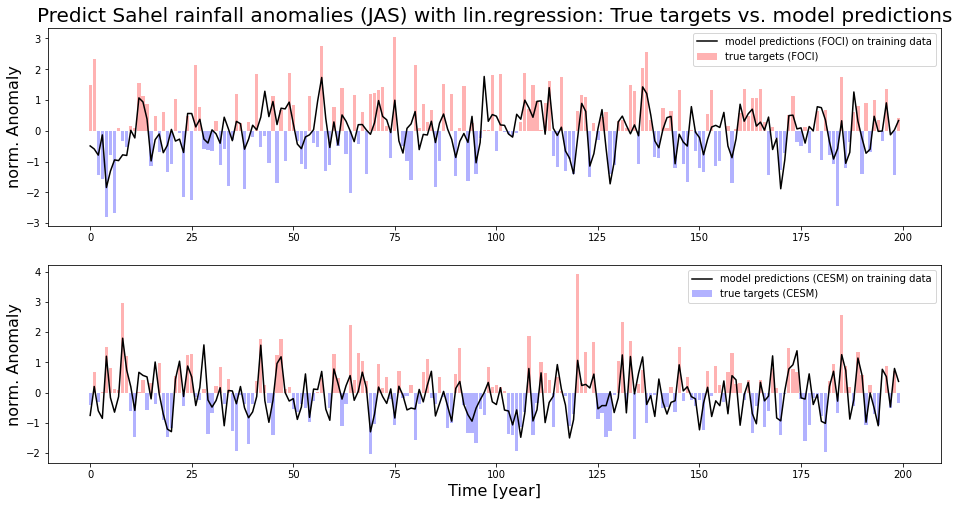

In [16]:
# Fidelity check: Plot TRAIN targets as bar plot (red / blue) vs. predictions as black line
fig, axes = plt.subplots(2,1,figsize=[16,8])

# FOCI
axes[0].bar(
    x=range(len(prec_sahel_FOCI_JAS.values[:200,0])),
    height=prec_sahel_FOCI_JAS.values[:200,0],
    color=bar_color(prec_sahel_FOCI_JAS[:200],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
axes[0].plot(train_pred_linReg_FOCI[:200,0], label="model predictions (FOCI) on training data", color='black')
axes[0].legend()
axes[0].set_title('Predict Sahel rainfall anomalies (JAS) with lin.regression: True targets vs. model predictions', fontsize=20)
#axes[0].set_xlabel('Time [year]', fontsize=16)
axes[0].set_ylabel('norm. Anomaly', fontsize=16)

# FOCI
axes[1].bar(
    x=range(len(prec_sahel_CESM_JAS.values[:200,0])),
    height=prec_sahel_CESM_JAS.values[:200,0],
    color=bar_color(prec_sahel_CESM_JAS[:200],'r','b')[0],
    label="true targets (CESM)",
    alpha=0.3
)
axes[1].plot(train_pred_linReg_CESM[:200,0], label="model predictions (CESM) on training data", color='black')
axes[1].legend()
axes[1].set_xlabel('Time [year]', fontsize=16)
axes[1].set_ylabel('norm. Anomaly', fontsize=16)

Text(0, 0.5, 'norm. Anomaly')

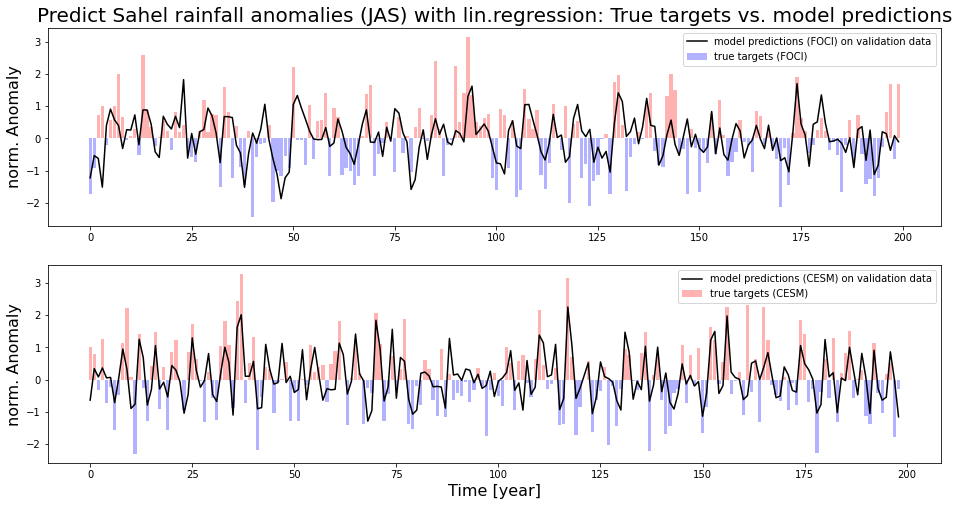

In [18]:
# Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line
fig, axes = plt.subplots(2,1,figsize=[16,8])

# FOCI
axes[0].bar(
    x=range(len(prec_sahel_FOCI_JAS.values[split:,0])),
    height=prec_sahel_FOCI_JAS.values[split:,0],
    color=bar_color(prec_sahel_FOCI_JAS[split:],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
axes[0].plot(val_pred_linReg_FOCI, label="model predictions (FOCI) on validation data", color='black')
axes[0].legend()
axes[0].set_title('Predict Sahel rainfall anomalies (JAS) with lin.regression: True targets vs. model predictions', fontsize=20)
#axes[0].set_xlabel('Time [year]', fontsize=16)
axes[0].set_ylabel('norm. Anomaly', fontsize=16)

# FOCI
axes[1].bar(
    x=range(len(prec_sahel_CESM_JAS.values[split:,0])),
    height=prec_sahel_CESM_JAS.values[split:,0],
    color=bar_color(prec_sahel_CESM_JAS[split:],'r','b')[0],
    label="true targets (CESM)",
    alpha=0.3
)
axes[1].plot(val_pred_linReg_CESM, label="model predictions (CESM) on validation data", color='black')
axes[1].legend()
axes[1].set_xlabel('Time [year]', fontsize=16)
axes[1].set_ylabel('norm. Anomaly', fontsize=16)

In [20]:
## Compute evaluation metrics: Linear regression on FOCI

# Check loss (mse) of true targets vs. model predictions:
print("Mean-squared error on train data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_FOCI[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_FOCI[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

## Get binary contingency table: TP, FP, TN, FN

# Training data:
TP_linReg_FOCI_train = np.sum(((train_target_FOCI.values>0)==(train_pred_linReg_FOCI>0)) & (train_target_FOCI.values>0)) / sum(train_target_FOCI.values>0)
FP_linReg_FOCI_train = np.sum(((train_target_FOCI.values<0)==(train_pred_linReg_FOCI>0)) & (train_target_FOCI.values<0)) / sum(train_target_FOCI.values<0)
TN_linReg_FOCI_train = np.sum(((train_target_FOCI.values<0)==(train_pred_linReg_FOCI<0)) & (train_target_FOCI.values<0)) / sum(train_target_FOCI.values<0)
FN_linReg_FOCI_train = np.sum(((train_target_FOCI.values>0)==(train_pred_linReg_FOCI<0)) & (train_target_FOCI.values>0)) / sum(train_target_FOCI.values>0)

# Validation data:
TP_linReg_FOCI_val = np.sum(((val_target_FOCI.values>0)==(val_pred_linReg_FOCI>0)) & (val_target_FOCI.values>0)) / sum(val_target_FOCI.values>0)
FP_linReg_FOCI_val = np.sum(((val_target_FOCI.values<0)==(val_pred_linReg_FOCI>0)) & (val_target_FOCI.values<0)) / sum(val_target_FOCI.values<0)
TN_linReg_FOCI_val = np.sum(((val_target_FOCI.values<0)==(val_pred_linReg_FOCI<0)) & (val_target_FOCI.values<0)) / sum(val_target_FOCI.values<0)
FN_linReg_FOCI_val = np.sum(((val_target_FOCI.values>0)==(val_pred_linReg_FOCI<0)) & (val_target_FOCI.values>0)) / sum(val_target_FOCI.values>0)

print("\nlinear Regression, FOCI:\n     TRAIN   VALIDATION")
print("TP: ", np.round(TP_linReg_FOCI_train[0],3),"  ", np.round(TP_linReg_FOCI_val[0],3))
print("FP: ", np.round(FP_linReg_FOCI_train[0],3),"  ",  np.round(FP_linReg_FOCI_val[0],3))
print("TN: ", np.round(TN_linReg_FOCI_train[0],3),"  ",  np.round(TN_linReg_FOCI_val[0],3))
print("FN: ", np.round(FN_linReg_FOCI_train[0],3),"  ",  np.round(FN_linReg_FOCI_val[0],3))

Mean-squared error on train data (FOCI) with lin. Reg.:  0.864
Mean-squared error on validation data (FOCI) with lin. Reg.:  0.827

Correlation on train data (FOCI) with lin. Reg.:  0.547
Correlation on validation data (FOCI) with lin. Reg.:  0.496

linear Regression, FOCI:
     TRAIN   VALIDATION
TP:  0.703    0.722
FP:  0.338    0.359
TN:  0.662    0.641
FN:  0.297    0.278


In [19]:
## Compute evaluation metrics: Linear regression on CESM

# Check loss (mse) of true targets vs. model predictions:
print("Mean-squared error on train data (CESM) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_CESM[:,0] - train_target_CESM.values[:,0])**2),3))
print("Mean-squared error on validation data (CESM) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_CESM[:,0] - val_target_CESM.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (CESM) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_CESM[:,0], train_target_CESM.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (CESM) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_CESM[:,0], val_target_CESM.values[:,0]]))[0,1],3)
     )

## Get binary contingency table: TP, FP, TN, FN

# Training data:
TP_linReg_CESM_train = np.sum(((train_target_CESM.values>0)==(train_pred_linReg_CESM>0)) & (train_target_CESM.values>0)) / sum(train_target_CESM.values>0)
FP_linReg_CESM_train = np.sum(((train_target_CESM.values<0)==(train_pred_linReg_CESM>0)) & (train_target_CESM.values<0)) / sum(train_target_CESM.values<0)
TN_linReg_CESM_train = np.sum(((train_target_CESM.values<0)==(train_pred_linReg_CESM<0)) & (train_target_CESM.values<0)) / sum(train_target_CESM.values<0)
FN_linReg_CESM_train = np.sum(((train_target_CESM.values>0)==(train_pred_linReg_CESM<0)) & (train_target_CESM.values>0)) / sum(train_target_CESM.values>0)

# Validation data:
TP_linReg_CESM_val = np.sum(((val_target_CESM.values>0)==(val_pred_linReg_CESM>0)) & (val_target_CESM.values>0)) / sum(val_target_CESM.values>0)
FP_linReg_CESM_val = np.sum(((val_target_CESM.values<0)==(val_pred_linReg_CESM>0)) & (val_target_CESM.values<0)) / sum(val_target_CESM.values<0)
TN_linReg_CESM_val = np.sum(((val_target_CESM.values<0)==(val_pred_linReg_CESM<0)) & (val_target_CESM.values<0)) / sum(val_target_CESM.values<0)
FN_linReg_CESM_val = np.sum(((val_target_CESM.values>0)==(val_pred_linReg_CESM<0)) & (val_target_CESM.values>0)) / sum(val_target_CESM.values>0)

print("\nlinear Regression, CESM:\n     TRAIN   VALIDATION")
print("TP: ", np.round(TP_linReg_CESM_train[0],3),"  ", np.round(TP_linReg_CESM_val[0],3))
print("FP: ", np.round(FP_linReg_CESM_train[0],3),"  ", np.round(FP_linReg_CESM_val[0],3))
print("TN: ", np.round(TN_linReg_CESM_train[0],3),"  ", np.round(TN_linReg_CESM_val[0],3))
print("FN: ", np.round(FN_linReg_CESM_train[0],3),"  ", np.round(FN_linReg_CESM_val[0],3))

Mean-squared error on train data (CESM) with lin. Reg.:  0.492
Mean-squared error on validation data (CESM) with lin. Reg.:  0.617

Correlation on train data (CESM) with lin. Reg.:  0.701
Correlation on validation data (CESM) with lin. Reg.:  0.682

linear Regression, CESM:
     TRAIN   VALIDATION
TP:  0.715    0.75
FP:  0.259    0.308
TN:  0.741    0.692
FN:  0.285    0.25


### Set up multilayer perceptron (MLP) for single run experiments on FOCI and CESM data

In [21]:
# Define customized metric function to compute Pearson's correlation coefficient 
# on true targets and model predictions.

def correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    sx = K.std(x)
    sy = K.std(y)
    xm, ym = x-mx, y-my
    r = K.mean(xm * ym) / (sx * sy)
    return r

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                580       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2022-12-05 08:53:40.916399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


80/80 - 1s - loss: 1.4319 - correlation_coefficient: 0.1886 - val_loss: 1.0089 - val_correlation_coefficient: 0.3058
Epoch 2/10
80/80 - 0s - loss: 1.1058 - correlation_coefficient: 0.3396 - val_loss: 0.9047 - val_correlation_coefficient: 0.3993
Epoch 3/10
80/80 - 0s - loss: 1.0199 - correlation_coefficient: 0.4094 - val_loss: 0.8584 - val_correlation_coefficient: 0.4370
Epoch 4/10
80/80 - 0s - loss: 0.9821 - correlation_coefficient: 0.4298 - val_loss: 0.8613 - val_correlation_coefficient: 0.4484
Epoch 5/10
80/80 - 0s - loss: 0.9602 - correlation_coefficient: 0.4638 - val_loss: 0.8401 - val_correlation_coefficient: 0.4560
Epoch 6/10
80/80 - 0s - loss: 0.9509 - correlation_coefficient: 0.4693 - val_loss: 0.8341 - val_correlation_coefficient: 0.4632
Epoch 7/10
80/80 - 0s - loss: 0.9385 - correlation_coefficient: 0.4839 - val_loss: 0.8274 - val_correlation_coefficient: 0.4672
Epoch 8/10
80/80 - 0s - loss: 0.9283 - correlation_coefficient: 0.4667 - val_loss: 0.8382 - val_correlation_coeffic

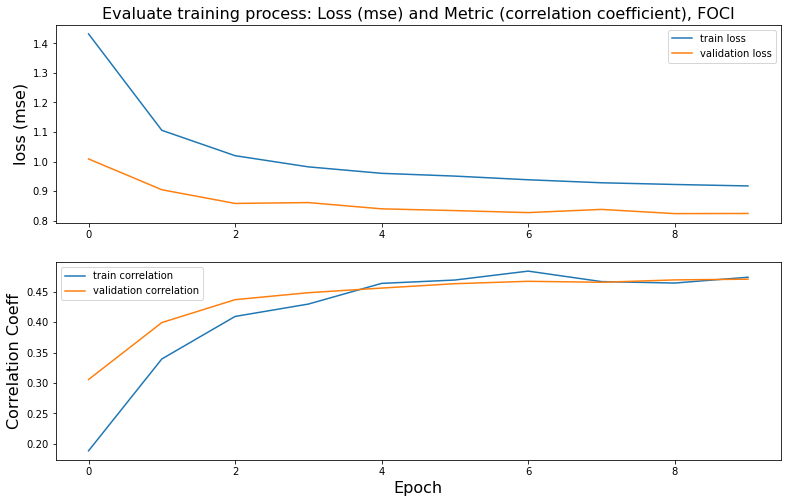

In [22]:
## MLP on FOCI:

## Set parameters upfront:
lr = 0.0005 # Learning rate
epc = 10 # Number of epochs
batch_size = 10 # Batch size
in_features = train_input_FOCI.shape[1] # Number of input features

# Optionally use L1 and/or L2 regularization drive small weights to zero or penalize large weights:
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0)

# Set up layers:
inputs = Input(shape=(in_features))
hidden_1 = Dense(20, activation='linear', kernel_regularizer=kernel_reg_Dense)(inputs)
hidden_2 = Dense(10, activation='linear', kernel_regularizer=kernel_reg_Dense)(hidden_1)
output = Dense(1, activation='linear')(hidden_2)

# Define and compile model :
model_MLP = Model(inputs, output, name='MLP')
opt = Adam(lr=lr) #SGD(lr=lr)
model_MLP.compile(loss='mse', optimizer=opt, metrics=[correlation_coefficient])
model_MLP.summary()

## train model on FOCI data:
history = model_MLP.fit(train_input_FOCI, train_target_FOCI, epochs=epc, verbose=2, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input_FOCI, val_target_FOCI))

# Plot loss (mse) and metric (correlation coefficient) on train and validation data (FOCI):
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].set_title("Evaluate training process: Loss (mse) and Metric (correlation coefficient), FOCI", fontsize=16)
axes[0].plot(history.history['loss'], label='train loss'), 
axes[0].plot(history.history['val_loss'], label='validation loss')
axes[0].set_ylabel("loss (mse)", fontsize=16)
axes[0].legend()
axes[1].plot(history.history['correlation_coefficient'], label='train correlation'), 
axes[1].plot(history.history['val_correlation_coefficient'], label='validation correlation')
axes[1].set_ylabel("Correlation Coeff", fontsize=16)
axes[1].legend()
axes[1].set_xlabel("Epoch", fontsize=16)
plt.show()

## Get model predictions on train and validation data:
train_pred_MLP_FOCI = model_MLP.predict(train_input_FOCI)
val_pred_MLP_FOCI = model_MLP.predict(val_input_FOCI)

In [23]:
## Save and re-load trained MLP model trained on FOCI data:

# !!! Note: To train and later re-load model, need to omit customized metric in compiling statement !!!

# ## Saved models for MLP experiments on FOCI inputs:
# model_MLP.save('../models/MLP_final/model_MLP_FOCI_SahelRain')


# ## Reload trained MLP model:
# model_MLP = tf.keras.models.load_model('../models/MLP_final/model_MLP_FOCI_SahelRain')

# ## Get model predictions on train and validation data:
# train_pred_MLP_FOCI = model_MLP.predict(train_input_FOCI)
# val_pred_MLP_FOCI = model_MLP.predict(val_input_FOCI)

In [39]:
## Compute evaluation metrics: MLP on FOCI

# Check loss (mse) of true targets vs. model predictions:
print("MLP:\n====\nMean-squared error on train data (FOCI) with MLP: ", 
      np.round(np.mean((train_pred_MLP_FOCI[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with MLP: ", 
      np.round(np.mean((val_pred_MLP_FOCI[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with MLP: ",
      np.round(np.corrcoef(np.stack([train_pred_MLP_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with MLP: ",
      np.round(np.corrcoef(np.stack([val_pred_MLP_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

## Compare with benchmark results from lin. Regression

# Check loss (mse) of true targets vs. model predictions:
print("\n\nlin. Regression:\n================\nMean-squared error on train data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_FOCI[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_FOCI[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

MLP:
====
Mean-squared error on train data (FOCI) with MLP:  0.881
Mean-squared error on validation data (FOCI) with MLP:  0.783

Correlation on train data (FOCI) with MLP:  0.534
Correlation on validation data (FOCI) with MLP:  0.523


lin. Regression:
Mean-squared error on train data (FOCI) with lin. Reg.:  0.864
Mean-squared error on validation data (FOCI) with lin. Reg.:  0.827

Correlation on train data (FOCI) with lin. Reg.:  0.547
Correlation on validation data (FOCI) with lin. Reg.:  0.496


In [40]:
# Check correlation of predictions from MLP and lin. regression (FOCI):
print("Correlation of predictions on train data from MLP and lin. Reg. (FOCI): ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI[:,0], train_pred_MLP_FOCI[:,0]]))[0,1],3)
     )
print("Correlation of predictions on validation data from MLP and lin. Reg. (FOCI): ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI[:,0], val_pred_MLP_FOCI[:,0]]))[0,1],3)
     )

Correlation of predictions on train data from MLP and lin. Reg. (FOCI):  0.977
Correlation of predictions on validation data from MLP and lin. Reg. (FOCI):  0.976


In [48]:
## Get binary contingency table: TP, FP, TN, FN

# TRAINING
TP_MLP_FOCI_train = np.sum(((train_target_FOCI.values>0)==(train_pred_MLP_FOCI>0)) & (train_target_FOCI.values>0)) / sum(train_target_FOCI.values>0)
FP_MLP_FOCI_train = np.sum(((train_target_FOCI.values<0)==(train_pred_MLP_FOCI>0)) & (train_target_FOCI.values<0)) / sum(train_target_FOCI.values<0)
TN_MLP_FOCI_train = np.sum(((train_target_FOCI.values<0)==(train_pred_MLP_FOCI<0)) & (train_target_FOCI.values<0)) / sum(train_target_FOCI.values<0)
FN_MLP_FOCI_train = np.sum(((train_target_FOCI.values>0)==(train_pred_MLP_FOCI<0)) & (train_target_FOCI.values>0)) / sum(train_target_FOCI.values>0)

# VALIDATION
TP_MLP_FOCI_val = np.sum(((val_target_FOCI.values>0)==(val_pred_MLP_FOCI>0)) & (val_target_FOCI.values>0)) / sum(val_target_FOCI.values>0)
FP_MLP_FOCI_val = np.sum(((val_target_FOCI.values<0)==(val_pred_MLP_FOCI>0)) & (val_target_FOCI.values<0)) / sum(val_target_FOCI.values<0)
TN_MLP_FOCI_val = np.sum(((val_target_FOCI.values<0)==(val_pred_MLP_FOCI<0)) & (val_target_FOCI.values<0)) / sum(val_target_FOCI.values<0)
FN_MLP_FOCI_val = np.sum(((val_target_FOCI.values>0)==(val_pred_MLP_FOCI<0)) & (val_target_FOCI.values>0)) / sum(val_target_FOCI.values>0)

print("\nMLP, FOCI:\n     TRAIN    VALIDATION")
print("TP: ", np.round(TP_MLP_FOCI_train[0],3),"  ", np.round(TP_MLP_FOCI_val[0],3))
print("FP: ", np.round(FP_MLP_FOCI_train[0],3),"  ", np.round(FP_MLP_FOCI_val[0],3))
print("TN: ", np.round(TN_MLP_FOCI_train[0],3),"  ", np.round(TN_MLP_FOCI_val[0],3))
print("FN: ", np.round(FN_MLP_FOCI_train[0],3),"  ", np.round(FN_MLP_FOCI_val[0],3))

print("\n\nlinear Regression, FOCI:\n     TRAIN   VALIDATION")
print("TP: ", np.round(TP_linReg_FOCI_train[0],3),"  ", np.round(TP_linReg_FOCI_val[0],3))
print("FP: ", np.round(FP_linReg_FOCI_train[0],3),"  ", np.round(FP_linReg_FOCI_val[0],3))
print("TN: ", np.round(TN_linReg_FOCI_train[0],3),"  ", np.round(TN_linReg_FOCI_val[0],3))
print("FN: ", np.round(FN_linReg_FOCI_train[0],3),"  ", np.round(FN_linReg_FOCI_val[0],3))


MLP, FOCI:
     TRAIN    VALIDATION
TP:  0.695    0.742
FP:  0.348    0.35
TN:  0.652    0.65
FN:  0.305    0.258


linear Regression, FOCI:
     TRAIN   VALIDATION
TP:  0.703    0.722
FP:  0.338    0.359
TN:  0.662    0.641
FN:  0.297    0.278


Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                580       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
80/80 - 0s - loss: 2.2160 - correlation_coefficient: 0.0777 - val_loss: 1.1503 - val_correlation_coefficient: 0.3561
Epoch 2/10
80/80 - 0s - loss: 0.9315 - correlation_coefficient: 0.3985 - val_loss: 0.8407 - val_correlation_coefficient: 0.5109
Epoch 3

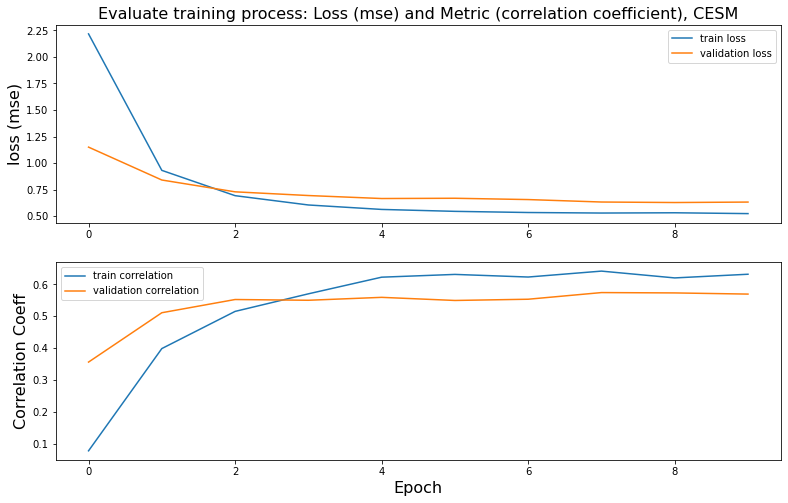

In [24]:
## Train MLP on CESM:

## Set parameters upfront:
lr = 0.0005 # Learning rate
epc = 10 # Number of epochs
batch_size = 10 # Batch size
in_features = train_input_CESM.shape[1] # Number of input features

# Optionally use L1 and/or L2 regularization drive small weights to zero or penalize large weights:
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0)

# Set up layers:
inputs = Input(shape=(in_features))
hidden_1 = Dense(20, activation='linear', kernel_regularizer=kernel_reg_Dense)(inputs)
hidden_2 = Dense(10, activation='linear', kernel_regularizer=kernel_reg_Dense)(hidden_1)
output = Dense(1, activation='linear')(hidden_2)

# Define and compile model :
model_MLP = Model(inputs, output, name='MLP')
opt = Adam(lr=lr) #SGD(lr=lr)
model_MLP.compile(loss='mse', optimizer=opt, metrics=[correlation_coefficient])
model_MLP.summary()

## train model on FOCI data:
history = model_MLP.fit(train_input_CESM, train_target_CESM, epochs=epc, verbose=2, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input_CESM, val_target_CESM))

# Plot loss (mse) and metric (correlation coefficient) on train and validation data (FOCI):
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].set_title("Evaluate training process: Loss (mse) and Metric (correlation coefficient), CESM", fontsize=16)
axes[0].plot(history.history['loss'], label='train loss'), 
axes[0].plot(history.history['val_loss'], label='validation loss')
axes[0].set_ylabel("loss (mse)", fontsize=16)
axes[0].legend()
axes[1].plot(history.history['correlation_coefficient'], label='train correlation'), 
axes[1].plot(history.history['val_correlation_coefficient'], label='validation correlation')
axes[1].set_ylabel("Correlation Coeff", fontsize=16)
axes[1].legend()
axes[1].set_xlabel("Epoch", fontsize=16)
plt.show()

## Get model predictions on train and validation data:
train_pred_MLP_CESM = model_MLP.predict(train_input_CESM)
val_pred_MLP_CESM = model_MLP.predict(val_input_CESM)

In [25]:
## Save and re-load trained MLP model trained on CESM data:

# !!! Note: To train and later re-load model, need to omit customized metric in compiling statement !!!

# ## Saved models for MLP experiments on CESM inputs:
# model_MLP.save('../models/MLP_final/model_MLP_CESM_SahelRain')


# ## Reload trained MLP model:
# model_MLP = tf.keras.models.load_model('../models/MLP_final/model_MLP_CESM_SahelRain')

# ## Get model predictions on train and validation data:
# train_pred_MLP_CESM = model_MLP.predict(train_input_CESM)
# val_pred_MLP_CESM = model_MLP.predict(val_input_CESM)

In [26]:
## Compute evaluation metrics: MLP on CESM

# Check loss (mse) of true targets vs. model predictions:
print("MLP:\n====\nMean-squared error on train data (CESM) with MLP: ", 
      np.round(np.mean((train_pred_MLP_CESM[:,0] - train_target_CESM.values[:,0])**2),3))
print("Mean-squared error on validation data (CESM) with MLP: ", 
      np.round(np.mean((val_pred_MLP_CESM[:,0] - val_target_CESM.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (CESM) with MLP: ",
      np.round(np.corrcoef(np.stack([train_pred_MLP_CESM[:,0], train_target_CESM.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (CESM) with MLP: ",
      np.round(np.corrcoef(np.stack([val_pred_MLP_CESM[:,0], val_target_CESM.values[:,0]]))[0,1],3)
     )

## Compare with benchmark results from lin. Regression

# Check loss (mse) of true targets vs. model predictions:
print("\n\nlin. Regression:\n================\nMean-squared error on train data (CESM) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_CESM[:,0] - train_target_CESM.values[:,0])**2),3))
print("Mean-squared error on validation data (CESM) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_CESM[:,0] - val_target_CESM.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (CESM) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_CESM[:,0], train_target_CESM.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (CESM) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_CESM[:,0], val_target_CESM.values[:,0]]))[0,1],3)
     )

MLP:
====
Mean-squared error on train data (CESM) with MLP:  0.513
Mean-squared error on validation data (CESM) with MLP:  0.597

Correlation on train data (CESM) with MLP:  0.686
Correlation on validation data (CESM) with MLP:  0.694


lin. Regression:
Mean-squared error on train data (CESM) with lin. Reg.:  0.492
Mean-squared error on validation data (CESM) with lin. Reg.:  0.617

Correlation on train data (CESM) with lin. Reg.:  0.701
Correlation on validation data (CESM) with lin. Reg.:  0.682


In [30]:
# Check correlation of predictions from MLP and lin. regression (CESM):
print("Correlation of predictions on train data from MLP and lin. Reg. (CESM): ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_CESM[:,0], train_pred_MLP_CESM[:,0]]))[0,1],3)
     )
print("Correlation of predictions on validation data from MLP and lin. Reg. (CESM): ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_CESM[:,0], val_pred_MLP_CESM[:,0]]))[0,1],3)
     )

Correlation of predictions on train data from MLP and lin. Reg. (CESM):  0.978
Correlation of predictions on validation data from MLP and lin. Reg. (CESM):  0.975


In [27]:
## Get binary contingency table: TP, FP, TN, FN

# TRAINING
TP_MLP_CESM_train = np.sum(((train_target_CESM.values>0)==(train_pred_MLP_CESM>0)) & (train_target_CESM.values>0)) / sum(train_target_CESM.values>0)
FP_MLP_CESM_train = np.sum(((train_target_CESM.values<0)==(train_pred_MLP_CESM>0)) & (train_target_CESM.values<0)) / sum(train_target_CESM.values<0)
TN_MLP_CESM_train = np.sum(((train_target_CESM.values<0)==(train_pred_MLP_CESM<0)) & (train_target_CESM.values<0)) / sum(train_target_CESM.values<0)
FN_MLP_CESM_train = np.sum(((train_target_CESM.values>0)==(train_pred_MLP_CESM<0)) & (train_target_CESM.values>0)) / sum(train_target_CESM.values>0)

# VALIDATION
TP_MLP_CESM_val = np.sum(((val_target_CESM.values>0)==(val_pred_MLP_CESM>0)) & (val_target_CESM.values>0)) / sum(val_target_CESM.values>0)
FP_MLP_CESM_val = np.sum(((val_target_CESM.values<0)==(val_pred_MLP_CESM>0)) & (val_target_CESM.values<0)) / sum(val_target_CESM.values<0)
TN_MLP_CESM_val = np.sum(((val_target_CESM.values<0)==(val_pred_MLP_CESM<0)) & (val_target_CESM.values<0)) / sum(val_target_CESM.values<0)
FN_MLP_CESM_val = np.sum(((val_target_CESM.values>0)==(val_pred_MLP_CESM<0)) & (val_target_CESM.values>0)) / sum(val_target_CESM.values>0)

print("\nMLP, CESM:\n     TRAIN    VALIDATION")
print("TP: ", np.round(TP_MLP_CESM_train[0],3),"  ", np.round(TP_MLP_CESM_val[0],3))
print("FP: ", np.round(FP_MLP_CESM_train[0],3),"  ", np.round(FP_MLP_CESM_val[0],3))
print("TN: ", np.round(TN_MLP_CESM_train[0],3),"  ", np.round(TN_MLP_CESM_val[0],3))
print("FN: ", np.round(FN_MLP_CESM_train[0],3),"  ", np.round(FN_MLP_CESM_val[0],3))

print("\n\nlinear Regression, CESM:\n     TRAIN   VALIDATION")
print("TP: ", np.round(TP_linReg_CESM_train[0],3),"  ", np.round(TP_linReg_CESM_val[0],3))
print("FP: ", np.round(FP_linReg_CESM_train[0],3),"  ", np.round(FP_linReg_CESM_val[0],3))
print("TN: ", np.round(TN_linReg_CESM_train[0],3),"  ", np.round(TN_linReg_CESM_val[0],3))
print("FN: ", np.round(FN_linReg_CESM_train[0],3),"  ", np.round(FN_linReg_CESM_val[0],3))


MLP, CESM:
     TRAIN    VALIDATION
TP:  0.72    0.75
FP:  0.266    0.28
TN:  0.734    0.72
FN:  0.28    0.25


linear Regression, CESM:
     TRAIN   VALIDATION
TP:  0.715    0.75
FP:  0.259    0.308
TN:  0.741    0.692
FN:  0.285    0.25


Text(0, 0.5, 'norm. Anomaly')

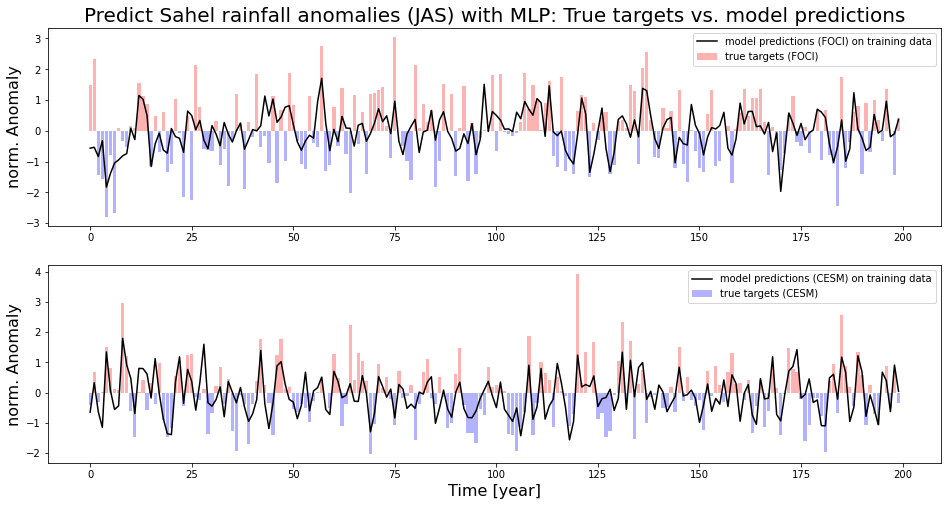

In [28]:
# Fidelity check: Plot TRAIN targets as bar plot (red / blue) vs. predictions as black line
fig, axes = plt.subplots(2,1,figsize=[16,8])

# FOCI
axes[0].bar(
    x=range(len(prec_sahel_FOCI_JAS.values[:200,0])),
    height=prec_sahel_FOCI_JAS.values[:200,0],
    color=bar_color(prec_sahel_FOCI_JAS[:200],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
axes[0].plot(train_pred_MLP_FOCI[:200,0], label="model predictions (FOCI) on training data", color='black')
axes[0].legend()
axes[0].set_title('Predict Sahel rainfall anomalies (JAS) with MLP: True targets vs. model predictions', fontsize=20)
#axes[0].set_xlabel('Time [year]', fontsize=16)
axes[0].set_ylabel('norm. Anomaly', fontsize=16)

# FOCI
axes[1].bar(
    x=range(len(prec_sahel_CESM_JAS.values[:200,0])),
    height=prec_sahel_CESM_JAS.values[:200,0],
    color=bar_color(prec_sahel_CESM_JAS[:200],'r','b')[0],
    label="true targets (CESM)",
    alpha=0.3
)
axes[1].plot(train_pred_MLP_CESM[:200,0], label="model predictions (CESM) on training data", color='black')
axes[1].legend()
axes[1].set_xlabel('Time [year]', fontsize=16)
axes[1].set_ylabel('norm. Anomaly', fontsize=16)

Text(0, 0.5, 'norm. Anomaly')

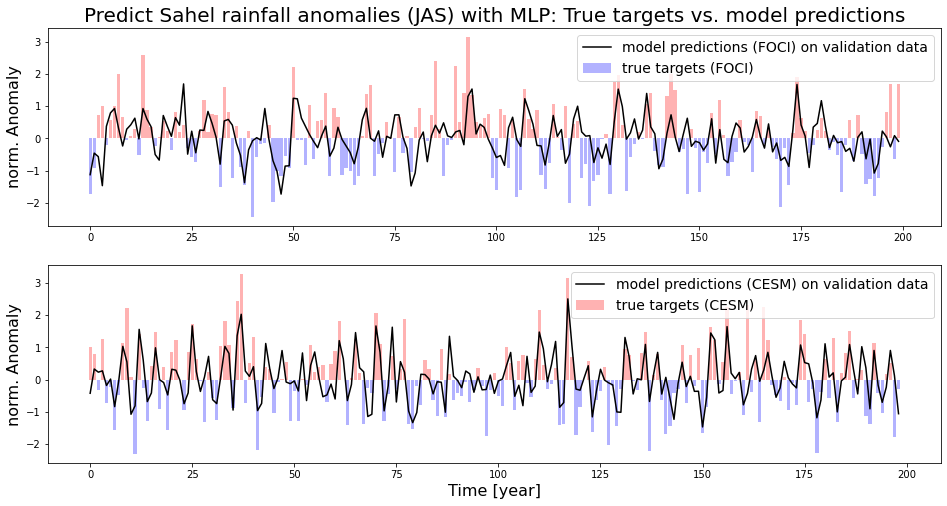

In [32]:
# Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line
fig, axes = plt.subplots(2,1,figsize=[16,8])

# FOCI
axes[0].bar(
    x=range(len(prec_sahel_FOCI_JAS.values[split:,0])),
    height=prec_sahel_FOCI_JAS.values[split:,0],
    color=bar_color(prec_sahel_FOCI_JAS[split:],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
axes[0].plot(val_pred_MLP_FOCI, label="model predictions (FOCI) on validation data", color='black')
axes[0].legend(fontsize=14)
axes[0].set_title('Predict Sahel rainfall anomalies (JAS) with MLP: True targets vs. model predictions', fontsize=20)
#axes[0].set_xlabel('Time [year]', fontsize=16)
axes[0].set_ylabel('norm. Anomaly', fontsize=16)

# FOCI
axes[1].bar(
    x=range(len(prec_sahel_CESM_JAS.values[split:,0])),
    height=prec_sahel_CESM_JAS.values[split:,0],
    color=bar_color(prec_sahel_CESM_JAS[split:],'r','b')[0],
    label="true targets (CESM)",
    alpha=0.3
)
axes[1].plot(val_pred_MLP_CESM, label="model predictions (CESM) on validation data", color='black')
axes[1].legend(fontsize=14)
axes[1].set_xlabel('Time [year]', fontsize=16)
axes[1].set_ylabel('norm. Anomaly', fontsize=16)

### Compare results from MLP model to predict Sahel Rainfall with linear regression (benchmark)

#### Setup
- In this experiment we used all indices from our CICMoD dataset as predictors, except Sahel Rainfall anomaly ("PREC_SAHEL"), since it was used as target.
- All input indicies have then been normalized to have zero mean and unit variance.

#### Experiment
- Tried multi-linear regression to set the benchmark.
- Then trained multilayer perceptron with two hidden layers with mean-squared-error loss and tracked correlation coefficient of true targets and model predictions as customized metric.
- Looked at binary contingency tables: TP, FP, TN, FN

#### Results
Started to train both models - linear regression and MLP - on FOCI data. The MLP model is found to train well, no signs of overfitting. Adding additional hidden layers doesn't improve model performance, but only forced the model to overfit on train data. Find somewhat poor correlation of about 50% on both - train and validation data, compared to [Badr et al., 2014], who show 81% / 71% correlation on real-world train and validation data, respectively.

Linear regression performs slightly better on training data, while MLP model marginally performs better on validation data. However, find the correlation between predictions from both models to be quite high (close to 1).

For CESM data, we find correlation significantly higher, compared to FOCI, in the range of 70%, which is comparable to [Badr et al.]. MLP again performs slightly better than linear regression on validation data, hence generalizes better!

This also reflects in contingency table.